# Downloading Stocks Data

In [11]:
!pip install yfinance

In [12]:
#Importing the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from pandas_datareader import data as pdr
from datetime import datetime
yf.pdr_override()
from google.colab import files

ModuleNotFoundError: No module named 'pandas_datareader'

In [ ]:
#Download file from https://www1.nseindia.com/content/indices/ind_nifty500list.csv and upload it here
#This file will be used to get the symbols of NSE 500 companies for getting their stock data

nse500 = files.upload()
nse500 = pd.read_csv('/content/ind_nifty500list.csv')
nse500

In [ ]:
#Generating tickers of NSE 500 companies

list_of_stocks=[]
for i in range(len(nse500)):
  list_of_stocks.append(nse500['Symbol'][i] + '.NS')
print(list_of_stocks)

In [ ]:
#Downloading stock data of NSE 500 companies from 2015 to 2020

start_date = datetime(2015,1,1)
end_date = datetime(2020,1,1)

stocks_data=[]

for i in list_of_stocks:
  stock=pdr.DataReader(i,start=start_date,end=end_date)
  if len(stock)>0:
    stocks_data.append(stock)

In [ ]:
#Checking stocks data

print(len(stocks_data))
stocks_data[0]

In [10]:
#Removing those stocks which do not have complete 5 year data and creating testing and training periods

date_division=datetime(2018,1,1)

stocks_data_training=pd.DataFrame(index=stocks_data[0][:date_division].index)
stocks_data_testing=pd.DataFrame(index=stocks_data[0][date_division:].index)
list_of_stocks_available=[]

for i in range(len(stocks_data)):
  if len(stocks_data[i])==len(stocks_data[0]):
    stocks_data_training['Adj Close '+ list_of_stocks[i]]=stocks_data[i]['Adj Close'][:date_division]
    stocks_data_testing['Adj Close '+ list_of_stocks[i]]=stocks_data[i]['Adj Close'][date_division:]
    list_of_stocks_available.append(list_of_stocks[i])


#Total number of stocks got for training and testing
print(len(stocks_data_training.columns)) 
print(len(stocks_data_testing.columns))
stocks_data_training

NameError: name 'datetime' is not defined

In [9]:
#Scaling the testing and training stock data

from sklearn.preprocessing import MinMaxScaler

scaler=MinMaxScaler()
scaled_stocks_data_training=scaler.fit_transform(stocks_data_training)
scaled_stocks_data_testing=scaler.fit_transform(stocks_data_testing)

scaled_stocks_data_training

NameError: name 'stocks_data_training' is not defined

# Mean Squred Error (MSE) 

In [5]:
#Defining function for calculating Mean Squared Error

def mse(data):
    d=data.T
    d1=np.tile(d,(d.shape[0],1,1))
    d2=np.tile(d,(1,1,d.shape[0])).reshape(d.shape[0],d.shape[0],d.shape[1])
    
    mse=d1-d2
    mse=mse**2
    mse=np.mean(mse,2)

    return mse

NameError: name 'd' is not defined

In [ ]:
#Finding Pairs through minimal MSE between stocks

mse_training_matrix=mse(scaled_stocks_data_training)
print(mse_training_matrix.shape)

threshold=0.005

a=np.where(mse_training_matrix<threshold,mse_training_matrix,-1)
arr_x=[]
arr_y=[]
for i in range(a.shape[0]):
  for j in range(i+1, a.shape[1]):
    if (a[i][j]!=-1):
      arr_x.append(i)
      arr_y.append(j)
arr_x=np.array(arr_x)
mse_pairs=[[i, j] for i, j in zip(arr_x, arr_y)]
print('Total number of MSE pairs = ',len(mse_pairs))

(356, 356)
Total number of MSE pairs =  116


# Cointegration

In [ ]:
#COINTEGRATION
import statsmodels.tsa.stattools as smts
import statsmodels.api as sm

def cointegration_pairs(df, non_stationary_cutoff = 0.05, coint_cutoff = 0.05, intercept = False, sig_level = 0.01):
    
    """
    df: is a 2d pandas dataframe or numpy array
    non_stationary_cutoff: if p value of the time series is >= this cutoff,
                            then the time series is non stationary.
                            ADFuller test is done to test if the time series 
                            is stationary or not.
    coint_cutoff: if p value of the time series is < this cutoff, then
                    the two time series will be cointegrated. 
                    Augmented engle-granger two-step cointegration test
                    is done to test if the pair is cointegrated.

    specify sig_level if intercept==True
    """

    if (isinstance(df, np.ndarray) == False):
        df = df.values
    
    #Finding Non Stationary Pairs
    non_stationary_stocks = []
    stationary_stocks = []
    for i in range(df.shape[1]):
        a = np.ravel(df[:,i])
        if smts.adfuller(a)[1] >= non_stationary_cutoff: 
            non_stationary_stocks.append(i)
        else:
            stationary_stocks.append(i)
    
    print('Total number of non stationary series are = ', len(non_stationary_stocks))
    print(non_stationary_stocks)
    print('Total number of stationary series are = ', len(stationary_stocks))
    print(stationary_stocks)

    #Finding cointegrated pairs
    coint_pairs = []
    pvalues = []
    for i in range(len(non_stationary_stocks)):
        for j in range(i+1, len(non_stationary_stocks)):
            if not intercept:
                a = np.ravel(df[:,non_stationary_stocks[i]])
                b = np.ravel(df[:,non_stationary_stocks[j]])
                k = smts.coint(a,b)[1]
                if k < coint_cutoff:
                    coint_pairs.append([non_stationary_stocks[i], non_stationary_stocks[j]])
                    pvalues.append(k)
            
            else:
                Y = np.ravel(df[:,non_stationary_stocks[i]])
                X = np.ravel(df[:,non_stationary_stocks[j]])
                X = sm.add_constant(X)

                model = sm.OLS(Y, X)
                results = model.fit()
                intercept, slope = results.params

                p_value = smts.adfuller(results.resid)[1]

                if p_value < sig_level and slope > 0:
                    coint_pairs.append([non_stationary_stocks[i], non_stationary_stocks[j]])
                    pvalues.append(p_value)

    coint_pairs = np.array(coint_pairs)
    pvalues = np.array(pvalues)

    argsort = np.argsort(pvalues)
    sorted_coint_pairs = []
    sorted_pvalues = []
    for i in argsort:
        sorted_pvalues.append(pvalues[i])
        sorted_coint_pairs.append(coint_pairs[i])
    
    sorted_coint_pairs = np.array(sorted_coint_pairs)
    sorted_pvalues = np.values = np.array(sorted_pvalues)

    return sorted_coint_pairs, sorted_pvalues

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Cointegration before clustering

coint_pairs, coint_pvalues = cointegration_pairs(scaled_stocks_data_training, 0.05, 0.01)
print(len(coint_pairs))
print(coint_pairs)

Total number of non stationary series are =  331
[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 14, 15, 16, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64, 65, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 99, 100, 101, 102, 103, 104, 105, 106, 107, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 131, 132, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 147, 148, 149, 151, 152, 153, 154, 155, 156, 157, 158, 160, 161, 162, 164, 165, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 2

# OPTICS

In [ ]:
#Appling Principal Components Ananlysis to reduce dimentionality of the scaled training stock data

from sklearn.decomposition import PCA

pca=PCA(n_components=10)  #Reducing dimentionality of stock data at particular dates to 10
returns_PCA=pca.fit_transform(stocks_data_training.values.transpose()) 

In [ ]:
from sklearn.cluster import OPTICS

optics = OPTICS(min_samples=5)
optics.fit(returns_PCA)

cluster_labels = optics.labels_ # dtype = list, index is asset
num_clusters = len(set(cluster_labels)) # number of clusters
all_clusters = np.unique(cluster_labels) # all cluster labels

# put every asset under its cluster label, in a dict asset_cluster_dict:
#  key: cluster label, dtype = int
#  value: asset indicies, dtype = list (of int)
cluster_asset_dict = {label: [] for label in all_clusters}
for asset_index, label in enumerate(cluster_labels):
    cluster_asset_dict[label].append(asset_index)
    
# values for clusters and assets for further analysis, without the noise cluster
## all cluster labels, not including the noise cluster
clusters_no_noise = np.delete(all_clusters, np.where(all_clusters == -1))
## all clusters' size, not including the noise cluster
cluster_size_no_noise = [len(cluster_asset_dict[cluster])
                         for cluster in clusters_no_noise]
## all assets that are not in the noise cluster
available_assets = []
for cluster in clusters_no_noise:
    available_assets += cluster_asset_dict[cluster]

In [ ]:
#Testing if optics worked correctly
print(cluster_size_no_noise)

all_assets = []
for cluster in all_clusters:
    all_assets += cluster_asset_dict[cluster]

print(len(all_assets))

[5, 5, 11, 13, 10, 7, 10, 8, 11]
356


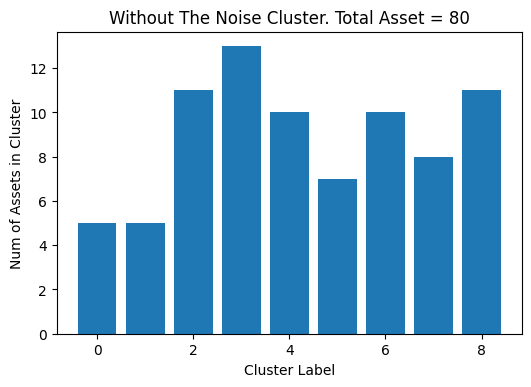

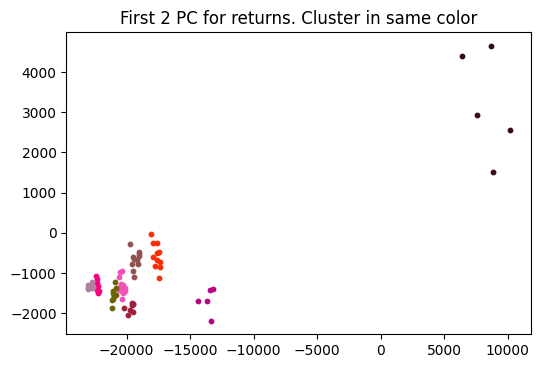

In [ ]:
# bar plot
plt.figure(dpi=100)
plt.bar(clusters_no_noise, cluster_size_no_noise)
plt.xlabel('Cluster Label')
plt.ylabel('Num of Assets in Cluster')
plt.title('Without The Noise Cluster. Total Asset = {}'.format(len(available_assets)))
plt.show()

# cluster w.r.t. the two principle components
colors = {cluster: np.random.rand(3) for cluster in clusters_no_noise}
plt.figure(dpi=100)
for asset in available_assets:
    plt.scatter(returns_PCA[asset, 0], returns_PCA[asset, 1], s=10,
                color=colors[cluster_labels[asset]])

plt.title('First 2 PC for returns. Cluster in same color')
plt.show()


# Cointegration and MSE after Clustering

In [ ]:
#Cointergration after Clustering

transposed_scaled_training_stock_data=scaled_stocks_data_training.T
transposed_scaled_test_stock_data=scaled_stocks_data_testing.T

cluster_training=[]
cluster_test=[]
coint_pairs_clustering=[] 
coint_pvalues_clustering=[]
for i in range(num_clusters):
  cluster_training.append(transposed_scaled_training_stock_data[cluster_asset_dict[list(cluster_asset_dict.keys())[i]]].T)
  cluster_test.append(transposed_scaled_test_stock_data[cluster_asset_dict[list(cluster_asset_dict.keys())[i]]].T)
  if(i>0):
    print("CLUSTER ",i)
    c1,c2=cointegration_pairs(cluster_training[i], 0.05, 0.01)
    coint_pairs_clustering.append(c1)
    coint_pvalues_clustering.append(c2)

#For more pairs, change coint_coefficient in cointegration function to 0.1 from 0.05

CLUSTER  1
Total number of non stationary series are =  3
[0, 2, 3]
Total number of stationary series are =  2
[1, 4]
CLUSTER  2
Total number of non stationary series are =  5
[0, 1, 2, 3, 4]
Total number of stationary series are =  0
[]
CLUSTER  3
Total number of non stationary series are =  6
[4, 5, 6, 7, 8, 10]
Total number of stationary series are =  5
[0, 1, 2, 3, 9]
CLUSTER  4
Total number of non stationary series are =  13
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Total number of stationary series are =  0
[]
CLUSTER  5
Total number of non stationary series are =  10
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Total number of stationary series are =  0
[]
CLUSTER  6
Total number of non stationary series are =  6
[0, 1, 2, 4, 5, 6]
Total number of stationary series are =  1
[3]
CLUSTER  7
Total number of non stationary series are =  9
[0, 1, 2, 3, 4, 5, 6, 7, 9]
Total number of stationary series are =  1
[8]
CLUSTER  8
Total number of non stationary series are =  8
[0, 1, 2, 3, 4, 5, 6, 7]
T

[]
[]
[]
[[ 1 11]
 [ 0 11]
 [ 0  4]
 [ 3 11]
 [11 12]]
76
BRIGADE
258
JUBLFOOD


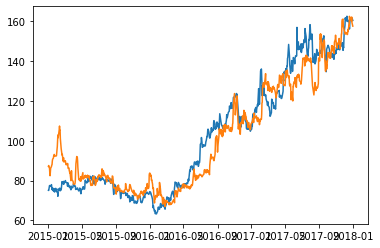

43
DMART
258
JUBLFOOD


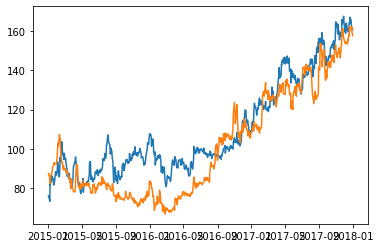

43
DMART
109
CAMS


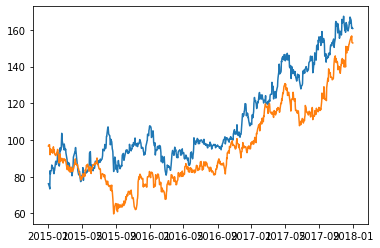

99
CHEMPLASTS
258
JUBLFOOD


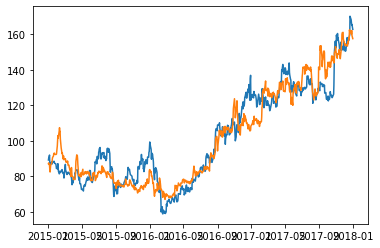

258
JUBLFOOD
304
MFSL


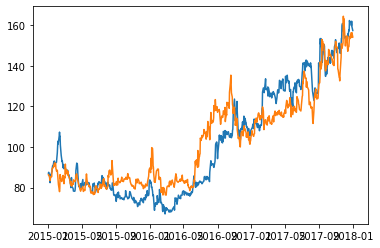

[[4 8]
 [4 5]]
127
LALPATHLAB
208
HDFC


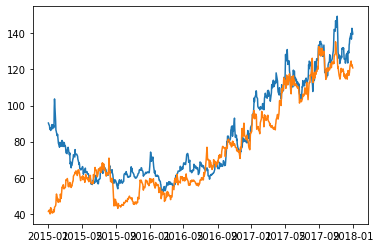

127
LALPATHLAB
174
GRINDWELL


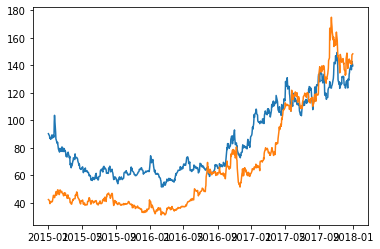

[[2 5]
 [5 6]
 [2 6]]
107
COFORGE
200
HINDCOPPER


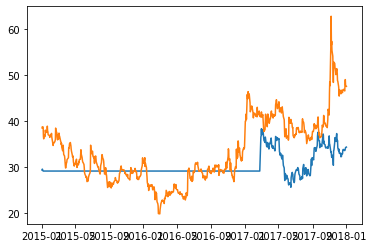

200
HINDCOPPER
228
IEX


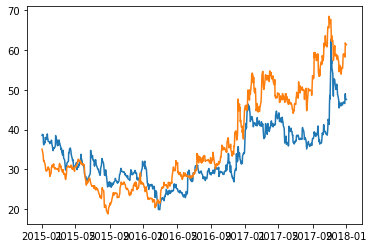

107
COFORGE
228
IEX


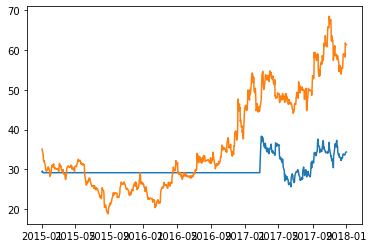

[[5 9]
 [0 7]]
269
KALPATPOWR
324
NTPC


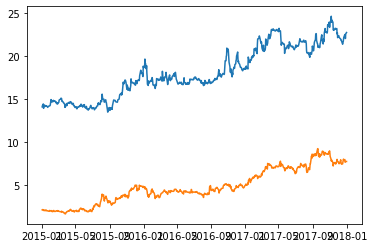

14
ABCAPITAL
297
MHRIL


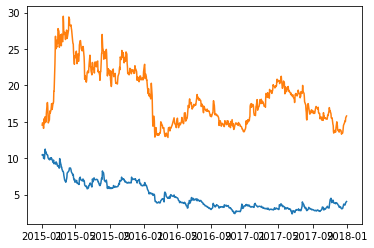

[]
[]


In [ ]:
#Making graphs of pairs found after cointegration

index=0;
for i in coint_pairs_clustering:
  print(i)
  for j in i:
    for k in j:
      print(cluster_asset_dict[index][k])
      print(nse500['Symbol'][cluster_asset_dict[index][k]])
      plt.plot(stocks_data_training.T.iloc[cluster_asset_dict[index][k]])
    plt.show()
  index=index+1

In [ ]:
#MSE after Clustering
threshold=0.015
mse_pairs_clustering=[]

for k in range(num_clusters):
  mse_training_matrix = mse(cluster_training[k])
  a=np.where(mse_training_matrix < threshold, mse_training_matrix, 4)
  arr_x=[]
  arr_y=[]
  for i in range(a.shape[0]):
    for j in range(i+1, a.shape[1]):
      if (a[i][j]!=4):
        arr_x.append(i)
        arr_y.append(j)
  arr_x=np.array(arr_x)
  mse_pairs_found=[[i, j] for i, j in zip(arr_x, arr_y)]
  mse_pairs_clustering.append(mse_pairs_found)
  if k>0:
    print('Total number of mse pairs in cluster using MSE',k,' = ',len(mse_pairs_clustering[k]))

Total number of mse pairs in cluster using MSE 1  =  0
Total number of mse pairs in cluster using MSE 2  =  6
Total number of mse pairs in cluster using MSE 3  =  0
Total number of mse pairs in cluster using MSE 4  =  13
Total number of mse pairs in cluster using MSE 5  =  13
Total number of mse pairs in cluster using MSE 6  =  0
Total number of mse pairs in cluster using MSE 7  =  1
Total number of mse pairs in cluster using MSE 8  =  13
Total number of mse pairs in cluster using MSE 9  =  0


[]
[[0, 2], [0, 4], [1, 2], [1, 3], [2, 3], [2, 4]]
73
BBTC
190
HAPPSTMNDS


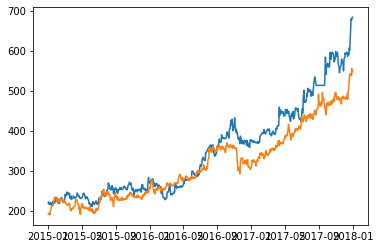

73
BBTC
343
PNCINFRA


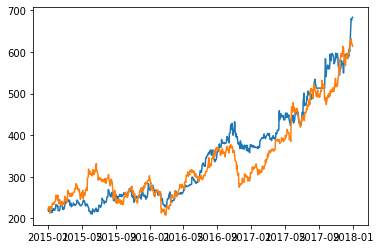

135
ELGIEQUIP
190
HAPPSTMNDS


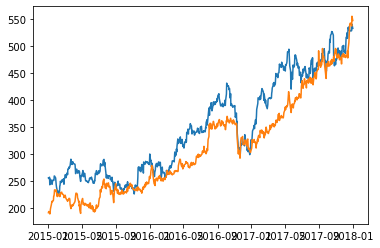

135
ELGIEQUIP
299
MANAPPURAM


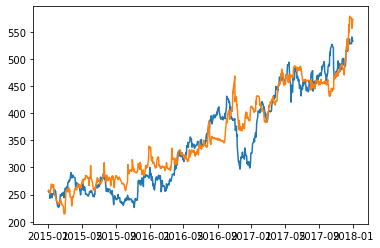

190
HAPPSTMNDS
299
MANAPPURAM


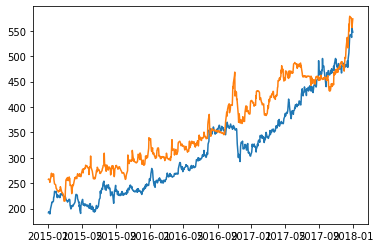

190
HAPPSTMNDS
343
PNCINFRA


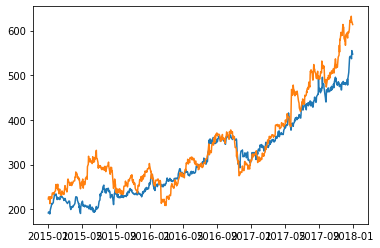

[]
[[0, 1], [0, 3], [0, 4], [0, 11], [1, 2], [1, 3], [1, 9], [1, 11], [2, 6], [3, 4], [3, 11], [4, 11], [11, 12]]
43
DMART
76
BRIGADE


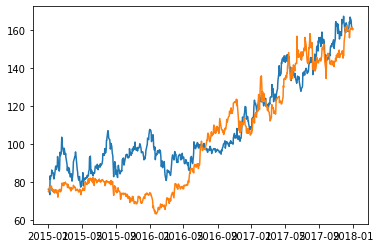

43
DMART
99
CHEMPLASTS


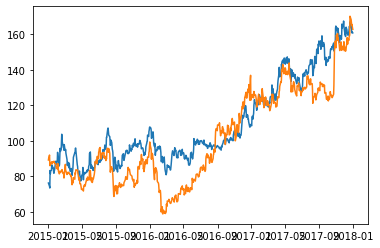

43
DMART
109
CAMS


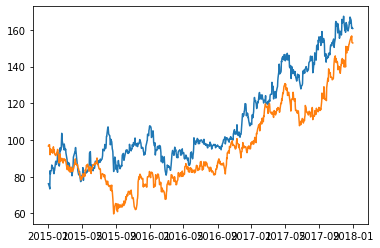

43
DMART
258
JUBLFOOD


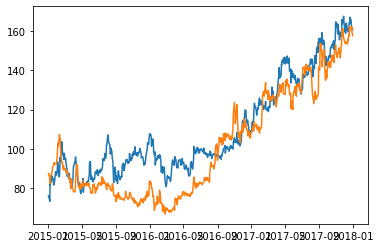

76
BRIGADE
94
CENTURYPLY


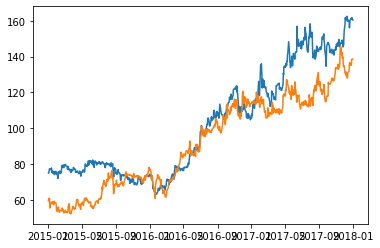

76
BRIGADE
99
CHEMPLASTS


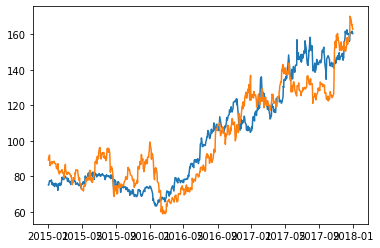

76
BRIGADE
250
JKPAPER


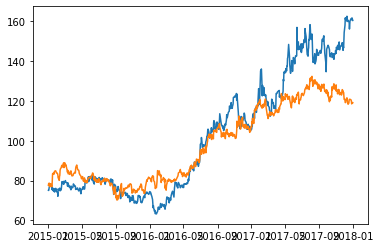

76
BRIGADE
258
JUBLFOOD


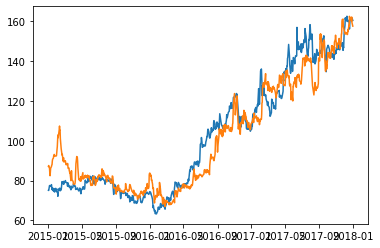

94
CENTURYPLY
184
HCLTECH


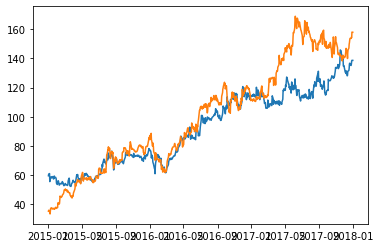

99
CHEMPLASTS
109
CAMS


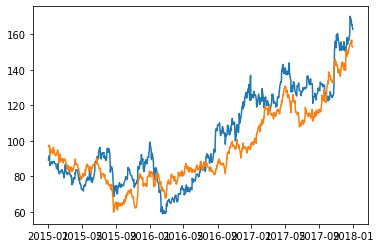

99
CHEMPLASTS
258
JUBLFOOD


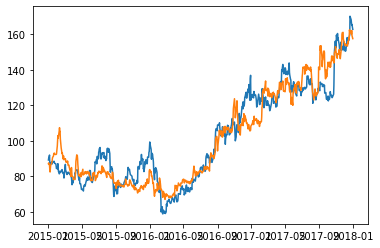

109
CAMS
258
JUBLFOOD


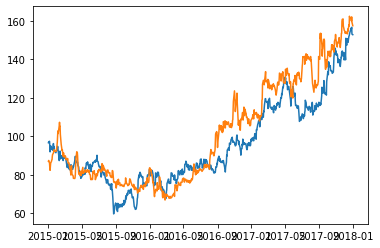

258
JUBLFOOD
304
MFSL


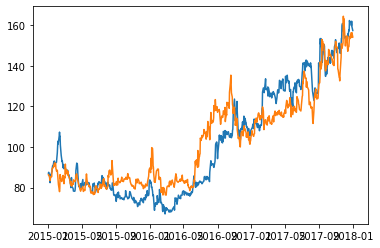

[[0, 5], [1, 5], [1, 6], [1, 9], [2, 8], [3, 8], [3, 9], [4, 5], [4, 8], [5, 6], [5, 9], [6, 9], [8, 9]]
72
BLUESTARCO
174
GRINDWELL


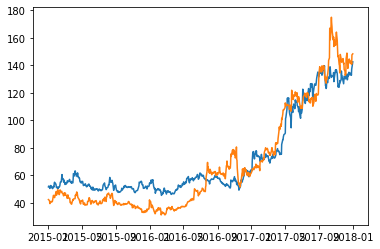

97
CHALET
174
GRINDWELL


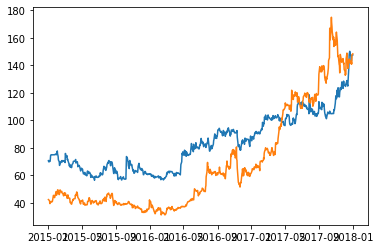

97
CHALET
186
HDFCBANK


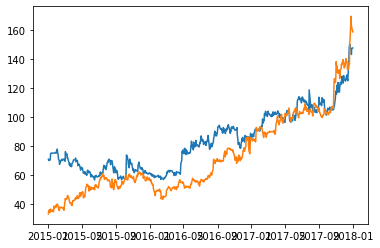

97
CHALET
220
IRCON


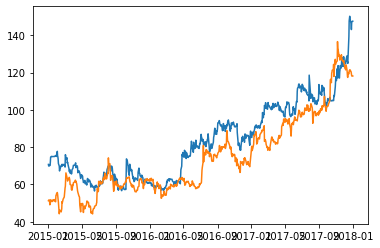

103
CUB
208
HDFC


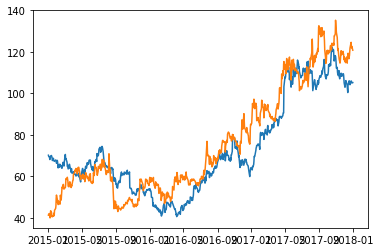

106
COCHINSHIP
208
HDFC


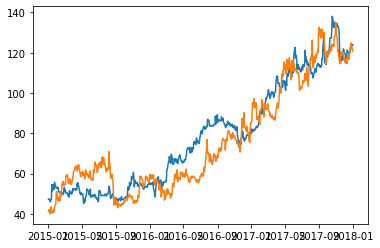

106
COCHINSHIP
220
IRCON


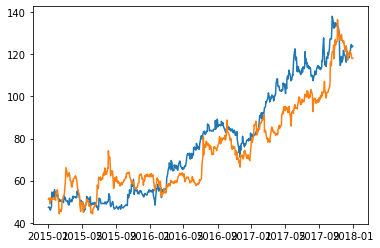

127
LALPATHLAB
174
GRINDWELL


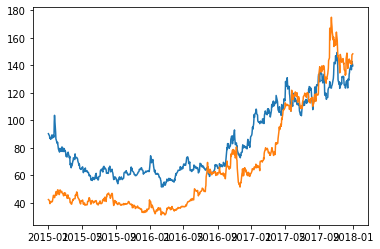

127
LALPATHLAB
208
HDFC


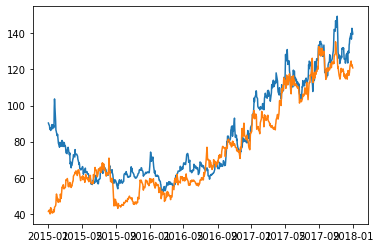

174
GRINDWELL
186
HDFCBANK


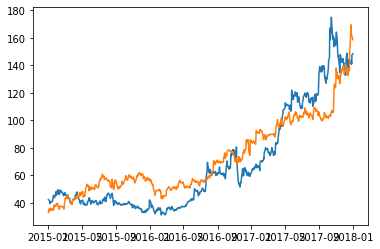

174
GRINDWELL
220
IRCON


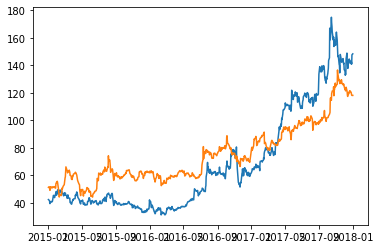

186
HDFCBANK
220
IRCON


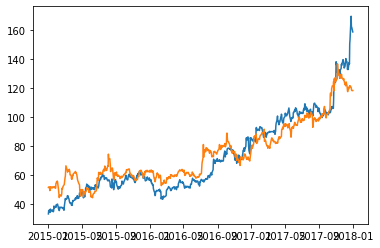

208
HDFC
220
IRCON


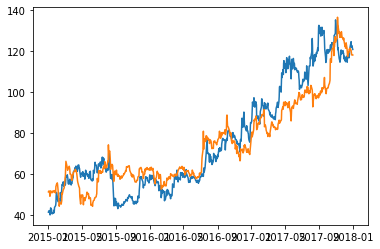

[]
[[5, 9]]
269
KALPATPOWR
324
NTPC


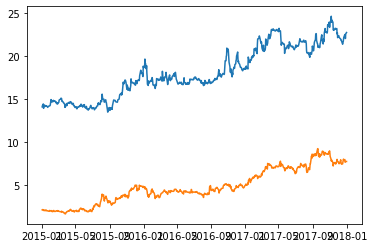

[[0, 1], [0, 5], [0, 6], [0, 7], [1, 3], [1, 7], [2, 3], [2, 7], [4, 5], [4, 6], [5, 6], [5, 7], [6, 7]]
9
ADANIENT
48
BAJAJELEC


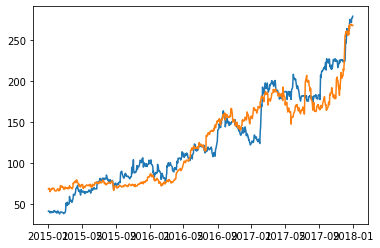

9
ADANIENT
176
GAEL


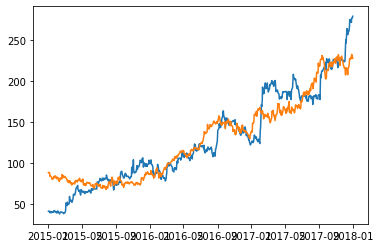

9
ADANIENT
241
NAUKRI


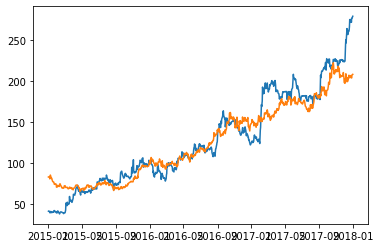

9
ADANIENT
333
OBEROIRLTY


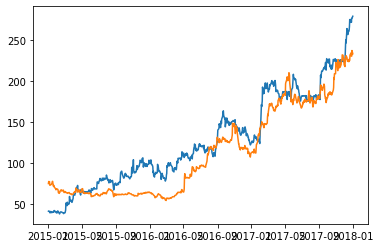

48
BAJAJELEC
88
CGCL


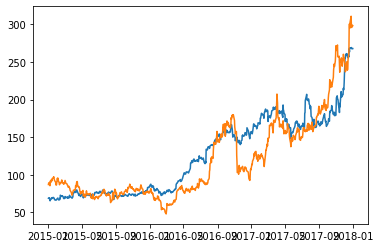

48
BAJAJELEC
333
OBEROIRLTY


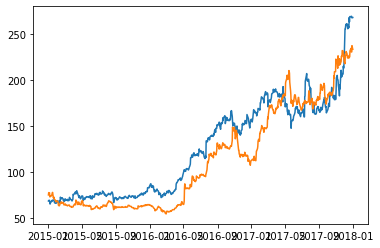

87
CAPLIPOINT
88
CGCL


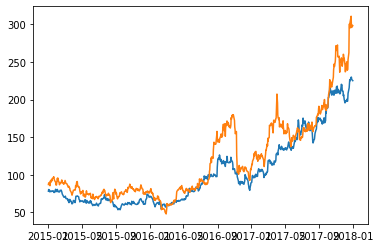

87
CAPLIPOINT
333
OBEROIRLTY


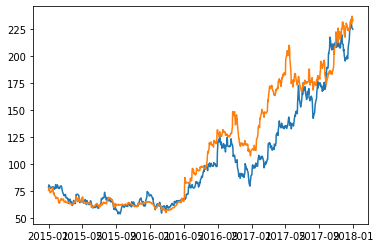

142
ESCORTS
176
GAEL


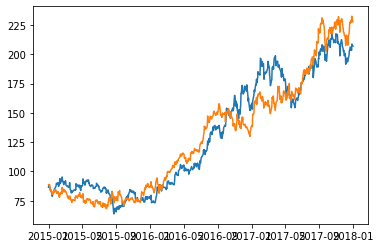

142
ESCORTS
241
NAUKRI


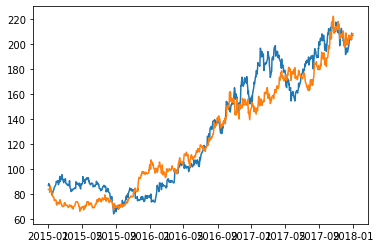

176
GAEL
241
NAUKRI


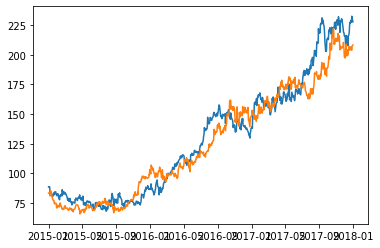

176
GAEL
333
OBEROIRLTY


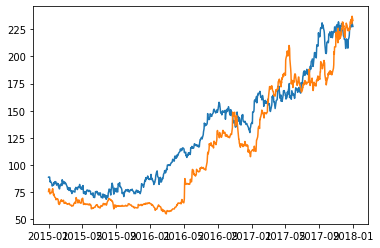

241
NAUKRI
333
OBEROIRLTY


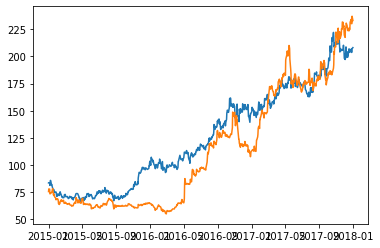

[]


In [ ]:
#Making graphs of pairs found after MSE

index=0;
for i in mse_pairs_clustering:
  if index==0:
    index=index+1
    continue
  print(i)
  for j in i:
    for k in j:
      print(cluster_asset_dict[index-1][k])
      print(nse500['Symbol'][cluster_asset_dict[index-1][k]])
      plt.plot(stocks_data_training.T.iloc[cluster_asset_dict[index-1][k]])
    plt.show()
  index=index+1

# Trading Strategy 

In [ ]:
# Regression based trading strategy

def regressionBacktest(training , testing , pairs , entry=2.5 , exit=1 , stoploss=100):
  import numpy as np
  import matplotlib.pyplot as plt
  from sklearn.linear_model import LinearRegression
  from sklearn.metrics import mean_squared_error, r2_score

  total_trades=0

  r = []

  for pair in pairs:  
    x = training.iloc[:,pair[0]].to_numpy()
    y = training.iloc[:,pair[1]].to_numpy()
    x = [[i] for i in x]
    regression_model = LinearRegression()

    regression_model.fit(x, y)

    y_predicted = regression_model.predict(x)
    residuals_train = y - y_predicted
    std_error = np.std(residuals_train)
    slope = regression_model.coef_
    intercept = regression_model.intercept_

    x2 = testing.iloc[:,pair[0]].to_numpy()
    y2 = testing.iloc[:,pair[1]].to_numpy()

    residue2 = (y2 - (slope*x2 + intercept))
    residueAll = np.append(residuals_train, residue2)
    
    score = []
    for i in range(len(residue2)):
      score.append(residue2[i]/(np.std(residueAll[:len(residuals_train)+1+i])))        ##

    #Trading in Testing period

    positionL=0
    positionS=0
    
    returns=1
    buyxL=0
    sellyL=0
    buyyS=0
    sellxS=0

    for i in range(len(score)-1):
      if score[i] > entry and positionL != 1:
        
        buyxL = x2[i+1]
        sellyL = y2[i+1]

        
        positionL=positionL+1

      elif (score[i] < exit or score[i] > stoploss) and positionL == 1:
        
        returns = returns*(1+(slope * (x2[i+1] - buyxL) + sellyL - y2[i+1])/(slope*buyxL + sellyL))

        
        positionL=positionL-1

      if score[i] < -1*entry and positionS != 1:
        
        buyyS = y2[i+1]
        sellxS = x2[i+1]

        
        positionS=positionS+1

      elif (score[i] > -1*exit or score[i] < -1*stoploss) and positionS == 1:
        
        returns = returns * (1+(slope*(sellxS - x2[i+1]) + y2[i+1] - buyyS)/(slope*sellxS + buyyS))
        positionS=positionS-1   

    r.append(returns)

  ## w/l ratio
  w = 0
  l = 0
  for ret in r:                   
    if(1-ret>0):
      w += 1
    elif (1-ret<0):
      l += 1
  if(l!=0):
    wl = w/l
  else:   #only wins no losses
    wl = w 

  ### net returns
  if(len(r)>0):
    netret = 0
    for ret in r:
      netret += ret
    netr = netret/len(r)-1
  else:   #in case of 0 profitable trades
    netr = 0

  return netr, wl

In [ ]:
# Backtesting on MSE pairs before clustering

Pairs = mse_pairs
entry = np.array([1.5])
exit = np.array([0.3])

s=0.0

rets = []
wls = []
#r, wl = regressionBacktest(training_stock_dataframe, testing_stock_dataframe, Pairs[2])
for en in entry:
  arr = []
  arr_wl = []
  for ex in exit:
    arr1 = []
    arr1_wl = []
    for p in Pairs:
      r, wl = regressionBacktest(stocks_data_training, stocks_data_testing, [p], entry=en, exit=ex)
      arr1.append(r)
      arr1_wl.append(wls)
    arr.append(arr1)
    arr_wl.append(arr1_wl)
  rets.append(arr)
  wls.append(arr_wl)
for i in rets[0][0]:
  s=s+i
print('Average returns = ', 100*s/len(rets[0][0]),'%')

Average returns =  [19.46678226] %


In [ ]:
# Backtesting MSE Pairs post clustering

s=0.0
l=0.0

for i in range(len(mse_pairs_clustering)):
  # Pairs = mse_pairs_clustering[i][:20]  #why [:20] ?
  if not mse_pairs_clustering[i]:
    continue
  Pairs = mse_pairs_clustering[i]
  entry = np.array([1.5])
  exit = np.array([0.3])

  rets = []
  wls = []
  #r, wl = regressionBacktest(training_stock_dataframe, testing_stock_dataframe, Pairs[2])
  for en in entry:
    arr = []
    arr_wl = []
    for ex in exit:
      arr1 = []
      arr1_wl = []
      for p in Pairs:
        r, wl = regressionBacktest(stocks_data_training, stocks_data_testing, [p], entry=en, exit=ex)
        arr1.append(r)
        arr1_wl.append(wls)
      arr.append(arr1)
      arr_wl.append(arr1_wl)
    rets.append(arr)
    wls.append(arr_wl)
  for i in rets[0][0]:
    s=s+i
    l=l+1
print('Average returns = ', 100*s/l,'%')

Average returns =  [3.55834324] %


In [ ]:
# Backtesting Cointegration pairs post clustering

s=0.0
l=0.0

for i in range(len(coint_pairs_clustering)):
  # if not coint_pairs_clustering[i]:
  #   continue
  Pairs = coint_pairs_clustering[i]
  entry = np.array([1.5])
  exit = np.array([0.3])

  rets = []
  wls = []
  #r, wl = regressionBacktest(training_stock_dataframe, testing_stock_dataframe, Pairs[2])
  for en in entry:
    arr = []
    arr_wl = []
    for ex in exit:
      arr1 = []
      arr1_wl = []
      for p in Pairs:
        r, wl = regressionBacktest(stocks_data_training, stocks_data_testing, [p], entry=en, exit=ex)
        arr1.append(r)
        arr1_wl.append(wls)
      arr.append(arr1)
      arr_wl.append(arr1_wl)
    rets.append(arr)
    wls.append(arr_wl)
  for i in rets[0][0]:
    s=s+i
    l=l+1
print('Average returns = ', 100*s/l,'%')

Average returns =  [19.46340188] %


In [ ]:
# Backtesting on cointegration pairs before clustering

Pairs = coint_pairs
entry = np.array([1.5])
exit = np.array([0.3])

s=0.0

rets = []
wls = []
#r, wl = regressionBacktest(training_stock_dataframe, testing_stock_dataframe, Pairs[2])
for en in entry:
  arr = []
  arr_wl = []
  for ex in exit:
    arr1 = []
    arr1_wl = []
    for p in Pairs:
      r, wl = regressionBacktest(stocks_data_training, stocks_data_testing, [p], entry=en, exit=ex)
      arr1.append(r)
      arr1_wl.append(wls)
    arr.append(arr1)
    arr_wl.append(arr1_wl)
  rets.append(arr)
  wls.append(arr_wl)
for i in rets[0][0]:
  s=s+i
print('Average returns = ', 100*s/len(rets[0][0]),'%')

Average returns =  [18.2773094] %
